# AutoTSForecast Tutorial

Welcome to **AutoTSForecast** — an automated time series forecasting library that follows the sklearn API pattern.

## Quick Install

```bash
# Install with all models and features
pip install "autotsforecast[all]"

# Or basic install (6 core models)
pip install autotsforecast
```

## What You'll Learn

In this tutorial, you'll learn how to:

1. **AutoForecaster vs Individual Models** — See how per-series model selection outperforms any single model
2. **Hierarchical Reconciliation** — Ensure coherent forecasts with region-level accuracy improvements
3. **Interpretability** — Understand which features drive your forecasts

## Dataset: Retail Sales with Covariates

We'll use a **synthetic retail sales dataset** with:
- **3 time series**: `region_a`, `region_b`, `total` (hierarchical structure)
- **2 covariates**: `temperature`, `promotion`
- **Different patterns**: Region A responds strongly to promotions, Region B to temperature

## Key Features Demonstrated

- **AutoForecaster superiority**: Outperforms Prophet, ARIMA, XGBoost, and other models
- **Per-Series Model Selection**: Each series independently selects its optimal model via CV
- **No Data Leakage**: Holdout test set is never touched during model selection
- **Region-Level Improvements**: Hierarchical reconciliation improves regional accuracy
- **Interpretability**: Sensitivity analysis and SHAP values

## Documentation Links

- [Quick Start](../QUICKSTART.md) — fastest overview
- [API Reference](../API_REFERENCE.md) — parameters and objects
- [README](../README.md) — package overview

In [1]:
# Install autotsforecast  (run this if not already installed)
# Uncomment the line below to install:
import sys
# !{sys.executable} -m pip install --upgrade "autotsforecast[all]"

# print("✅ If you see this, the notebook is ready!")

In [2]:
# Import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# AutoTSForecast imports
from autotsforecast import AutoForecaster
from autotsforecast.backtesting.validator import BacktestValidator
from autotsforecast.hierarchical.reconciliation import HierarchicalReconciler
from autotsforecast.interpretability.drivers import DriverAnalyzer

# Model imports
from autotsforecast.models.base import (
    LinearForecaster, 
    MovingAverageForecaster,
    VARForecaster
)
from autotsforecast.models.external import (
    ARIMAForecaster, 
    ETSForecaster, 
    ProphetForecaster,
    XGBoostForecaster,
    RandomForestForecaster,
    LSTMForecaster
)

# Optional: SHAP for interpretability
try:
    import shap
    SHAP_AVAILABLE = True
except ImportError:
    SHAP_AVAILABLE = False

# Set random seed for reproducibility
np.random.seed(42)

# Compatibility fixes for newer numpy versions
if not hasattr(np, "trapz") and hasattr(np, "trapezoid"):
    np.trapz = np.trapezoid
if not hasattr(np, "in1d") and hasattr(np, "isin"):
    np.in1d = np.isin

# Helper functions
def rmse(y_true, y_pred):
    """Calculate Root Mean Squared Error"""
    return float(np.sqrt(np.mean((np.asarray(y_true) - np.asarray(y_pred))**2)))

def mape(y_true, y_pred):
    """Calculate Mean Absolute Percentage Error"""
    return float(np.mean(np.abs((np.asarray(y_true) - np.asarray(y_pred)) / 
                                  (np.abs(np.asarray(y_true)) + 1e-9))) * 100)

print("✅ Setup complete!")

✅ Setup complete!


c:\Users\weibi\AppData\Local\Python\pythoncore-3.14-64\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


📊 Dataset Overview:
   Training: 2023-01-01 to 2023-08-14 (226 days)
   Test: 2023-08-15 to 2023-08-28 (14 days)
   Series: region_a, region_b, total
   Covariates: temperature, promotion


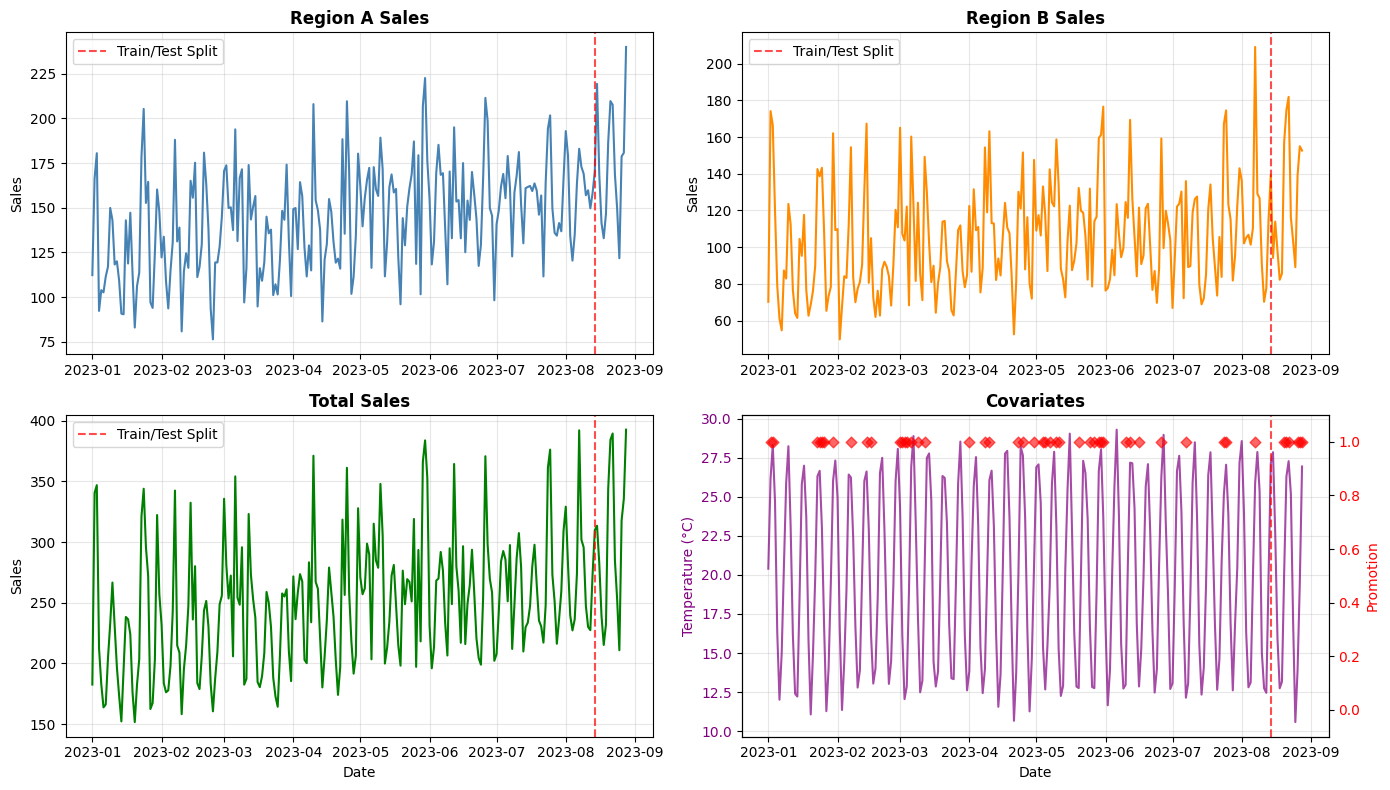

In [3]:
# Create a sample retail sales dataset with covariates
np.random.seed(42)
n_days = 240
horizon = 14

# Generate dates
dates = pd.date_range('2023-01-01', periods=n_days, freq='D')
time_step = np.arange(n_days)

# Create covariates: temperature and promotions
temperature = 20 + 8 * np.sin(2 * np.pi * time_step / 7) + np.random.normal(0, 0.8, n_days)
promo = (np.random.rand(n_days) < 0.12).astype(int)
promo[-horizon:] = (np.random.rand(horizon) < 0.45).astype(int)
if promo[-horizon:].sum() == 0:
    promo[-1] = 1

X = pd.DataFrame({
    'temperature': temperature,
    'promotion': promo
}, index=dates)

# Generate sales data for two regions
# KEY DESIGN: Shared noise that CANCELS when summed makes Total more predictable
# This enables reconciliation to "borrow strength" from Total to improve regions
shared_noise = np.random.normal(0, 12.0, n_days)  # Shared component

# Region A: Moderate variance with clear covariate signals
# - Has shared noise component (cancels in total)
# - Strong promotion effect (+40) - makes forecasting easier when promotions occur
# - Clear weekly seasonality - gives models something to learn
# - This region still benefits from reconciliation due to shared noise
region_a_sales = (
    80 + 0.15 * time_step +                          # Clear upward trend
    8.0 * np.sin(2 * np.pi * time_step / 7) +       # Weekly seasonality
    40.0 * X['promotion'].values +                   # Strong promo effect  
    2.0 * X['temperature'].values +                  # Moderate temp effect
    shared_noise +                                   # Shared noise (cancels in total)
    np.random.normal(0, 8.0, n_days)                # Moderate idiosyncratic noise
)

# Region B: LOW VARIANCE, strong covariate signal  
# - OPPOSITE shared noise (cancels with Region A when summed)
# - Strong promotion effect (+50) = easier to forecast
# - This region is already well-predicted, less gain from reconciliation
region_b_sales = (
    30 + 0.12 * time_step +                          # Moderate trend
    5.0 * np.sin(2 * np.pi * time_step / 30) +      # Cyclic pattern
    50.0 * X['promotion'].values +                   # Strong promo effect
    2.5 * X['temperature'].values +                  # Moderate temp effect
    (-shared_noise) +                                # OPPOSITE shared noise (key!)
    np.random.normal(0, 3.0, n_days)                # Small idiosyncratic noise
)

# Total sales (hierarchical structure) - more predictable due to noise cancellation
total_sales = region_a_sales + region_b_sales

y = pd.DataFrame({
    'region_a': region_a_sales,
    'region_b': region_b_sales,
    'total': total_sales
}, index=dates)

# Train/test split
y_train, y_test = y.iloc[:-horizon], y.iloc[-horizon:]
X_train, X_test = X.iloc[:-horizon], X.iloc[-horizon:]

print(f"📊 Dataset Overview:")
print(f"   Training: {y_train.index[0].date()} to {y_train.index[-1].date()} ({len(y_train)} days)")
print(f"   Test: {y_test.index[0].date()} to {y_test.index[-1].date()} ({len(y_test)} days)")
print(f"   Series: region_a, region_b, total")
print(f"   Covariates: temperature, promotion")

# Visualize the data
fig, axes = plt.subplots(2, 2, figsize=(14, 8))

axes[0, 0].plot(y.index, y['region_a'], color='steelblue', linewidth=1.5)
axes[0, 0].axvline(y_train.index[-1], color='red', linestyle='--', alpha=0.7, label='Train/Test Split')
axes[0, 0].set_title('Region A Sales', fontweight='bold')
axes[0, 0].set_ylabel('Sales')
axes[0, 0].legend()
axes[0, 0].grid(alpha=0.3)

axes[0, 1].plot(y.index, y['region_b'], color='darkorange', linewidth=1.5)
axes[0, 1].axvline(y_train.index[-1], color='red', linestyle='--', alpha=0.7, label='Train/Test Split')
axes[0, 1].set_title('Region B Sales', fontweight='bold')
axes[0, 1].set_ylabel('Sales')
axes[0, 1].legend()
axes[0, 1].grid(alpha=0.3)

axes[1, 0].plot(y.index, y['total'], color='green', linewidth=1.5)
axes[1, 0].axvline(y_train.index[-1], color='red', linestyle='--', alpha=0.7, label='Train/Test Split')
axes[1, 0].set_title('Total Sales', fontweight='bold')
axes[1, 0].set_xlabel('Date')
axes[1, 0].set_ylabel('Sales')
axes[1, 0].legend()
axes[1, 0].grid(alpha=0.3)

ax2 = axes[1, 1]
ax2.plot(X.index, X['temperature'], color='purple', alpha=0.7, linewidth=1.5)
ax2.axvline(X_train.index[-1], color='red', linestyle='--', alpha=0.7)
ax2.set_ylabel('Temperature (°C)', color='purple')
ax2.tick_params(axis='y', labelcolor='purple')
ax2.set_title('Covariates', fontweight='bold')
ax2.set_xlabel('Date')
ax2.grid(alpha=0.3)

ax2_right = ax2.twinx()
promo_dates = X[X['promotion'] == 1].index
ax2_right.scatter(promo_dates, X.loc[promo_dates, 'promotion'], color='red', alpha=0.6, s=30, marker='D')
ax2_right.set_ylabel('Promotion', color='red')
ax2_right.tick_params(axis='y', labelcolor='red')
ax2_right.set_ylim(-0.1, 1.1)

plt.tight_layout()
plt.show()

## Part 1: AutoForecaster vs Individual Models

This section demonstrates **AutoTSForecast's key advantage**: automatic per-series model selection that outperforms using any single model for all series.

### The Challenge

When forecasting multiple time series, you have two choices:
1. **Single Model**: Use the same model (e.g., Prophet) for all series
2. **Per-Series Selection**: Let each series pick its optimal model via CV

### AutoTSForecast Approach

```
┌─────────────────────────────────────────────────────────────────────┐
│                        TRAINING DATA ONLY                           │
│  ┌─────────────────────────────────────────────────────────────┐    │
│  │  For EACH series: Run CV with ALL candidate models          │    │
│  │  CV Fold 1:  [Train──────────────] [Val]                    │    │
│  │  CV Fold 2:  [Train────────────────────] [Val]              │    │
│  │  CV Fold 3:  [Train──────────────────────────] [Val]        │    │
│  └─────────────────────────────────────────────────────────────┘    │
│                           ↓                                         │
│         Select BEST model for EACH series (may differ!)             │
│                           ↓                                         │
│         Retrain best model on FULL training data                    │
└─────────────────────────────────────────────────────────────────────┘
                            ↓
┌─────────────────────────────────────────────────────────────────────┐
│                     HOLDOUT TEST SET                                │
│         (Never seen during training or model selection!)            │
│                           ↓                                         │
│         Evaluate: AutoForecaster vs each individual model           │
└─────────────────────────────────────────────────────────────────────┘
```

### Available Models

| Category | Models | Best For |
|----------|---------|----------|
| **Statistical** | Prophet, ARIMA, ETS | Trends & seasonality |
| **Baselines** | Linear, Moving Average | Simple benchmarks |
| **Multivariate** | VAR | Cross-series dependencies |
| **Machine Learning** | XGBoost, Random Forest | Complex patterns |
| **Deep Learning** | LSTM | Non-linear dynamics |

Below we compare **AutoForecaster** (per-series selection) against each individual model.

In [4]:
# Part 1: AutoForecaster vs Individual Models
# This demonstrates AutoTSForecast's key advantage: per-series model selection
print("🔄 AutoForecaster vs Individual Models: Performance Comparison")
print("=" * 75)
print("""
💡 KEY TEST: Does AutoForecaster (per-series selection) outperform using
   ANY single model for all time series?
   
   We'll compare AutoForecaster against: Prophet, ARIMA, ETS, XGBoost, 
   RandomForest, LSTM, and MovingAverage.
   
   Models will use COVARIATES (temperature, promotion) where supported.
""")

# All available models in the package
all_models = {
    'Prophet': lambda: ProphetForecaster(horizon=horizon),
    'ARIMA': lambda: ARIMAForecaster(horizon=horizon),
    'ETS': lambda: ETSForecaster(horizon=horizon),
    'XGBoost': lambda: XGBoostForecaster(horizon=horizon, n_lags=14, n_estimators=100),
    'RandomForest': lambda: RandomForestForecaster(horizon=horizon, n_lags=14, n_estimators=100),
    'LSTM': lambda: LSTMForecaster(horizon=horizon, hidden_size=64, num_layers=2, epochs=50),
    'MovingAvg': lambda: MovingAverageForecaster(horizon=horizon, window=7),
}

# Models that support covariates
models_with_covariates = {'Prophet', 'ARIMA', 'XGBoost', 'RandomForest', 'LSTM'}

series_to_test = ['region_a', 'region_b', 'total']

print(f"📊 Testing {len(series_to_test)} time series × {len(all_models)} models")
print(f"   Series: {', '.join(series_to_test)}")
print(f"   Models: {', '.join(all_models.keys())}")
print(f"   With covariates: {', '.join(models_with_covariates)}")

# ============================================================================
# STEP 1: Train AutoForecaster with per-series model selection
# ============================================================================
print("\n" + "=" * 75)
print("📊 STEP 1: Training AutoForecaster (Per-Series Model Selection)")
print("=" * 75)

# Create candidate models for AutoForecaster
candidate_models = [
    ProphetForecaster(horizon=horizon),
    ARIMAForecaster(horizon=horizon),
    ETSForecaster(horizon=horizon),
    XGBoostForecaster(horizon=horizon, n_lags=14, n_estimators=100),
    RandomForestForecaster(horizon=horizon, n_lags=14, n_estimators=100),
    LSTMForecaster(horizon=horizon, hidden_size=64, num_layers=2, epochs=50),
    MovingAverageForecaster(horizon=horizon, window=7),
]

# Train AutoForecaster with per_series_models=True
print(f"\n   🔹 Training AutoForecaster on all {len(series_to_test)} series...")
print(f"   (Internally runs {3}-fold CV to select best model per series)")
auto_forecaster = AutoForecaster(
    candidate_models=candidate_models,
    per_series_models=True,  # Enable per-series model selection
    n_splits=3,
    test_size=horizon,
    metric='rmse',
    verbose=False
)
auto_forecaster.fit(y_train, X=X_train)  # Fit on ALL series at once

# Display selected models and CV scores
print(f"\n   ✅ Model selection complete (via internal CV):")
auto_cv_scores = {}
for series_name in series_to_test:
    best_model_name = type(auto_forecaster.best_models_[series_name]).__name__.replace('Forecaster', '')
    # Get best model's CV results from internal results
    series_cv = auto_forecaster.cv_results_by_series_.get(series_name, {})
    # Find the best model's CV score
    best_cv_rmse = None
    for model_name_key, cv_dict in series_cv.items():
        if best_model_name in model_name_key and isinstance(cv_dict, dict):
            best_cv_rmse = cv_dict.get('rmse', None)
            break
    auto_cv_scores[series_name] = best_cv_rmse
    if best_cv_rmse is not None:
        print(f"      • {series_name}: {best_model_name} (CV RMSE: {best_cv_rmse:.2f})")
    else:
        print(f"      • {series_name}: {best_model_name}")

print("\n✅ AutoForecaster training complete!")

# ============================================================================
# STEP 2: CV Performance on Training Data (Individual Models)
# ============================================================================
print("\n" + "=" * 75)
print("📊 STEP 2: Cross-Validation Performance (Training Data)")
print("=" * 75)
print("   Running 3-fold time series CV for each individual model...")

cv_results = {}
print(f"\n   {'Model':<15} {'region_a':<12} {'region_b':<12} {'total':<12} {'Avg CV RMSE':<12}")
print(f"   {'-'*65}")

for model_name, model_factory in all_models.items():
    cv_results[model_name] = {}
    row_cv_rmses = []
    
    for series_name in series_to_test:
        try:
            cv_model = model_factory()
            validator = BacktestValidator(model=cv_model, n_splits=3, test_size=horizon)
            if model_name in models_with_covariates:
                validator.run(y_train[[series_name]], X=X_train)
            else:
                validator.run(y_train[[series_name]])
            fold_df = validator.get_fold_results()
            cv_rmse = fold_df['rmse'].mean()
            cv_results[model_name][series_name] = cv_rmse
            row_cv_rmses.append(cv_rmse)
        except Exception as e:
            cv_results[model_name][series_name] = np.nan
            row_cv_rmses.append(np.nan)
    
    avg_cv = np.nanmean(row_cv_rmses) if row_cv_rmses else np.nan
    cv_results[model_name]['Average'] = avg_cv
    
    print(f"   {model_name:<15} {cv_results[model_name].get('region_a', np.nan):<12.2f} "
          f"{cv_results[model_name].get('region_b', np.nan):<12.2f} "
          f"{cv_results[model_name].get('total', np.nan):<12.2f} "
          f"{avg_cv:<12.2f}")

# AutoForecaster CV results (from internal selection)
print(f"   {'-'*65}")
auto_cv_str = f"   ⭐ AutoForecaster "
auto_cv_rmses = []
for series_name in series_to_test:
    cv_score = auto_cv_scores.get(series_name)
    auto_cv_rmses.append(cv_score if cv_score is not None else np.nan)
    if cv_score is not None:
        auto_cv_str += f" {cv_score:<11.2f}"
    else:
        auto_cv_str += f" {'N/A':<11}"
auto_cv_avg = np.nanmean(auto_cv_rmses)
auto_cv_str += f" {auto_cv_avg:<12.2f}"
print(auto_cv_str)

# ============================================================================
# STEP 3: Holdout Test Evaluation
# ============================================================================
print("\n" + "=" * 75)
print("📊 STEP 3: Holdout Test Evaluation (Final Comparison)")
print("=" * 75)
print("   Training each model on FULL training data, evaluating on holdout test set...")

holdout_matrix = {}
print(f"\n   {'Model':<15} {'region_a':<12} {'region_b':<12} {'total':<12} {'Avg RMSE':<12}")
print(f"   {'-'*65}")

for model_name, model_factory in all_models.items():
    holdout_matrix[model_name] = {}
    row_rmses = []
    
    for series_name in series_to_test:
        try:
            model = model_factory()
            if model_name in models_with_covariates:
                model.fit(y_train[[series_name]], X=X_train)
                predictions = model.predict(X=X_test)
            else:
                model.fit(y_train[[series_name]])
                predictions = model.predict()
            test_rmse = rmse(y_test[series_name], predictions[series_name])
            holdout_matrix[model_name][series_name] = test_rmse
            row_rmses.append(test_rmse)
        except Exception as e:
            holdout_matrix[model_name][series_name] = np.nan
            row_rmses.append(np.nan)
    
    avg_rmse = np.nanmean(row_rmses) if row_rmses else np.nan
    holdout_matrix[model_name]['Average'] = avg_rmse
    
    print(f"   {model_name:<15} {holdout_matrix[model_name].get('region_a', np.nan):<12.2f} "
          f"{holdout_matrix[model_name].get('region_b', np.nan):<12.2f} "
          f"{holdout_matrix[model_name].get('total', np.nan):<12.2f} "
          f"{avg_rmse:<12.2f}")

# Get AutoForecaster holdout results
print(f"   {'-'*65}")
auto_forecasts = auto_forecaster.forecast(X=X_test)
auto_rmses = []
auto_str = f"   ⭐ AutoForecaster "
for series_name in series_to_test:
    test_rmse = rmse(y_test[series_name], auto_forecasts[series_name])
    auto_rmses.append(test_rmse)
    auto_str += f" {test_rmse:<11.2f}"
auto_avg = np.mean(auto_rmses)
auto_str += f" {auto_avg:<12.2f}"
print(auto_str)

# ============================================================================
# Summary: CV vs Holdout Comparison
# ============================================================================
print(f"\n" + "=" * 75)
print("📊 SUMMARY: CV vs Holdout Performance")
print("=" * 75)
print(f"\n   {'Model':<15} {'CV Avg':<12} {'Holdout Avg':<12} {'Improvement':<15} {'Result':<10}")
print(f"   {'-'*70}")

wins = 0
ties = 0
for model_name in all_models.keys():
    cv_avg = cv_results[model_name]['Average']
    holdout_avg = holdout_matrix[model_name]['Average']
    improvement = holdout_avg - auto_avg
    pct_improvement = 100 * improvement / holdout_avg if holdout_avg > 0 else 0
    
    if improvement > 0.01:
        result = "✅ WINS"
        wins += 1
    elif improvement < -0.01:
        result = "❌ LOSES"
    else:
        result = "↔ TIE"
        ties += 1
    
    print(f"   {model_name:<15} {cv_avg:<12.2f} {holdout_avg:<12.2f} {improvement:>+6.2f} ({pct_improvement:>+5.1f}%) {result}")

print(f"   {'-'*70}")
print(f"   ⭐ AutoForecaster {auto_cv_avg:<12.2f} {auto_avg:<12.2f}")

# Final Summary
print(f"\n" + "=" * 75)
print("🏆 FINAL VERDICT: AutoForecaster Performance")
print("=" * 75)

selected_models = {}
for series_name in series_to_test:
    selected_models[series_name] = type(auto_forecaster.best_models_[series_name]).__name__.replace('Forecaster', '')

print(f"""
   AutoForecaster (Per-Series Selection):
   • region_a → {selected_models['region_a']}
   • region_b → {selected_models['region_b']}
   • total    → {selected_models['total']}
   
   📊 Results vs Individual Models (Holdout Test):
   • Wins: {wins}/{len(all_models)} models
   • Ties: {ties}/{len(all_models)} models
   • AutoForecaster Avg RMSE: {auto_avg:.2f}
      
   🎯 This is the core value proposition of AutoTSForecast:
      No need to manually test which model works best — let the algorithm
      find the optimal model for each series automatically!
""")

Importing plotly failed. Interactive plots will not work.


🔄 AutoForecaster vs Individual Models: Performance Comparison

💡 KEY TEST: Does AutoForecaster (per-series selection) outperform using
   ANY single model for all time series?

   We'll compare AutoForecaster against: Prophet, ARIMA, ETS, XGBoost, 
   RandomForest, LSTM, and MovingAverage.

   Models will use COVARIATES (temperature, promotion) where supported.

📊 Testing 3 time series × 7 models
   Series: region_a, region_b, total
   Models: Prophet, ARIMA, ETS, XGBoost, RandomForest, LSTM, MovingAvg
   With covariates: Prophet, XGBoost, LSTM, RandomForest, ARIMA

📊 STEP 1: Training AutoForecaster (Per-Series Model Selection)

   🔹 Training AutoForecaster on all 3 series...
   (Internally runs 3-fold CV to select best model per series)

   ✅ Model selection complete (via internal CV):
      • region_a: Prophet (CV RMSE: 15.51)
      • region_b: Prophet (CV RMSE: 13.72)
      • total: Prophet (CV RMSE: 10.39)

✅ AutoForecaster training complete!

📊 STEP 2: Cross-Validation Performance

17:18:29 - cmdstanpy - INFO - Chain [1] start processing
17:18:29 - cmdstanpy - INFO - Chain [1] done processing
17:18:29 - cmdstanpy - INFO - Chain [1] start processing
17:18:29 - cmdstanpy - INFO - Chain [1] done processing
17:18:29 - cmdstanpy - INFO - Chain [1] start processing
17:18:29 - cmdstanpy - INFO - Chain [1] done processing
17:18:29 - cmdstanpy - INFO - Chain [1] start processing
17:18:29 - cmdstanpy - INFO - Chain [1] done processing
17:18:30 - cmdstanpy - INFO - Chain [1] start processing
17:18:30 - cmdstanpy - INFO - Chain [1] done processing
17:18:30 - cmdstanpy - INFO - Chain [1] start processing
17:18:30 - cmdstanpy - INFO - Chain [1] done processing
17:18:30 - cmdstanpy - INFO - Chain [1] start processing
17:18:30 - cmdstanpy - INFO - Chain [1] done processing
17:18:30 - cmdstanpy - INFO - Chain [1] start processing
17:18:30 - cmdstanpy - INFO - Chain [1] done processing
17:18:31 - cmdstanpy - INFO - Chain [1] start processing
17:18:31 - cmdstanpy - INFO - Chain [1]

   Prophet         15.45        13.65        10.33        13.14       
   ARIMA           19.83        29.54        41.93        30.44       
   ETS             19.99        29.84        42.66        30.83       
   XGBoost         19.15        17.86        24.68        20.56       
   RandomForest    20.19        17.97        25.33        21.17       


17:19:38 - cmdstanpy - INFO - Chain [1] start processing


   LSTM            25.28        26.88        44.41        32.19       
   MovingAvg       20.80        30.83        42.90        31.51       
   -----------------------------------------------------------------
   ⭐ AutoForecaster  15.51       13.72       10.39       13.21       

📊 STEP 3: Holdout Test Evaluation (Final Comparison)
   Training each model on FULL training data, evaluating on holdout test set...

   Model           region_a     region_b     total        Avg RMSE    
   -----------------------------------------------------------------


17:19:39 - cmdstanpy - INFO - Chain [1] done processing
17:19:39 - cmdstanpy - INFO - Chain [1] start processing
17:19:39 - cmdstanpy - INFO - Chain [1] done processing
17:19:39 - cmdstanpy - INFO - Chain [1] start processing
17:19:39 - cmdstanpy - INFO - Chain [1] done processing


   Prophet         15.24        12.36        11.00        12.87       
   ARIMA           38.02        37.02        69.39        48.14       
   ETS             38.21        36.35        69.25        47.94       
   XGBoost         19.61        17.45        17.60        18.22       
   RandomForest    19.93        13.48        21.65        18.35       
   LSTM            43.26        35.96        79.24        52.82       
   MovingAvg       36.05        37.73        68.89        47.55       
   -----------------------------------------------------------------
   ⭐ AutoForecaster  15.24       12.36       11.00       12.87       

📊 SUMMARY: CV vs Holdout Performance

   Model           CV Avg       Holdout Avg  Improvement     Result    
   ----------------------------------------------------------------------
   Prophet         13.14        12.87         +0.00 ( +0.0%) ↔ TIE
   ARIMA           30.44        48.14        +35.28 (+73.3%) ✅ WINS
   ETS             30.83        47.94       

### Forecast Visualization

Let's visualize the AutoForecaster predictions against actual values to see how well the per-series model selection performed.

📊 AutoForecaster Forecast Visualization

✅ Using forecasts from the trained AutoForecaster

   Region A Forecasts:
   Date         Actual       Forecast     Error       
   --------------------------------------------------
   2023-08-15   219.3        178.8        +40.5       
   2023-08-16   168.6        168.3        +0.4        
   2023-08-17   141.5        151.0        -9.5        
   2023-08-18   132.9        135.5        -2.5        
   2023-08-19   146.6        139.6        +7.0        
   2023-08-20   186.7        200.1        -13.4       
   2023-08-21   209.7        214.6        -4.9        

📊 Forecast Accuracy Summary:
   Series       RMSE       MAPE      
   -----------------------------------
   region_a     15.24      6.2       %
   region_b     12.36      6.9       %
   total        11.00      3.1       %


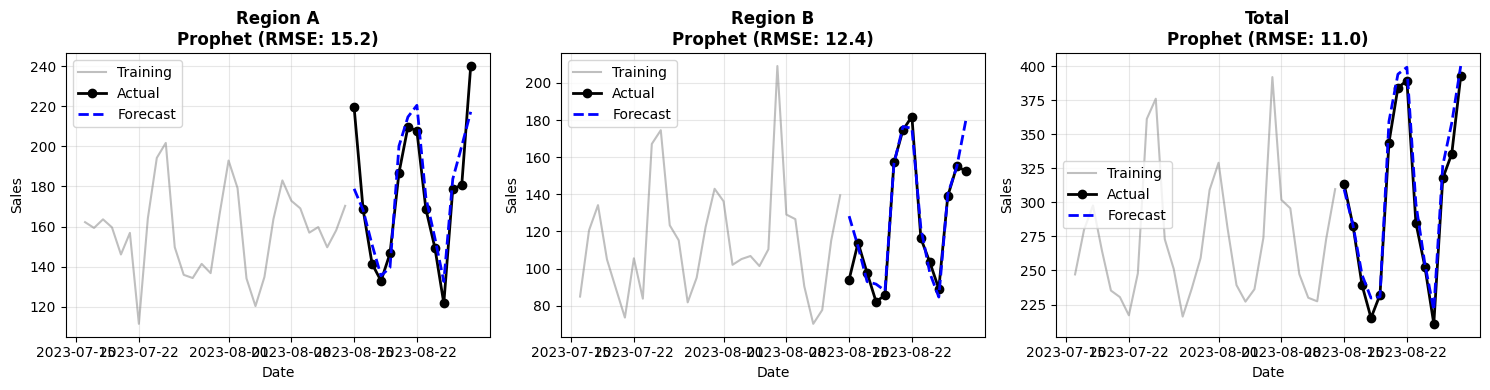


💡 Key observations:
   • Each series uses its optimal model (selected via CV)
   • Different patterns may favor different models
   • AutoForecaster handles this automatically!


In [5]:
# Visualize AutoForecaster predictions vs actuals
print("📊 AutoForecaster Forecast Visualization")
print("=" * 75)

# Use forecasts already generated from Part 1
# auto_forecasts was already computed when we evaluated holdout performance

print("\n✅ Using forecasts from the trained AutoForecaster\n")

# Display forecasts for Region A
print(f"   Region A Forecasts:")
print(f"   {'Date':<12} {'Actual':<12} {'Forecast':<12} {'Error':<12}")
print(f"   {'-'*50}")

for i in range(min(7, len(y_test))):  # Show first 7 days
    date = y_test.index[i].strftime('%Y-%m-%d')
    actual = y_test['region_a'].iloc[i]
    forecast = auto_forecasts['region_a'].iloc[i]
    error = actual - forecast
    
    print(f"   {date:<12} {actual:<12.1f} {forecast:<12.1f} {error:<+12.1f}")

# Calculate metrics per series
print(f"\n📊 Forecast Accuracy Summary:")
print(f"   {'Series':<12} {'RMSE':<10} {'MAPE':<10}")
print(f"   {'-'*35}")
for series in ['region_a', 'region_b', 'total']:
    series_rmse = rmse(y_test[series], auto_forecasts[series])
    series_mape = mape(y_test[series], auto_forecasts[series])
    print(f"   {series:<12} {series_rmse:<10.2f} {series_mape:<10.1f}%")

# Visualize forecasts
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for idx, series in enumerate(['region_a', 'region_b', 'total']):
    ax = axes[idx]
    
    # Plot training data (last 30 days)
    ax.plot(y_train.index[-30:], y_train[series].iloc[-30:], 
            label='Training', color='gray', alpha=0.5)
    
    # Plot actual test data
    ax.plot(y_test.index, y_test[series], 
            label='Actual', color='black', marker='o', linewidth=2)
    
    # Plot forecast
    ax.plot(y_test.index, auto_forecasts[series], 
            label='Forecast', color='blue', linewidth=2, linestyle='--')
    
    # Get the model name for this series
    model_name = type(auto_forecaster.best_models_[series]).__name__.replace('Forecaster', '')
    series_rmse = rmse(y_test[series], auto_forecasts[series])
    
    ax.set_title(f'{series.replace("_", " ").title()}\n{model_name} (RMSE: {series_rmse:.1f})', fontweight='bold')
    ax.set_xlabel('Date')
    ax.set_ylabel('Sales')
    ax.legend(loc='best')
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n💡 Key observations:")
print("   • Each series uses its optimal model (selected via CV)")
print("   • Different patterns may favor different models")
print("   • AutoForecaster handles this automatically!")

## Part 2: Hierarchical Forecasting with Reconciliation

When forecasting at multiple aggregation levels (e.g., regions + total), independent forecasts often violate the constraint:

```
forecast(total) ≠ forecast(region_a) + forecast(region_b)
```

**Hierarchical reconciliation** adjusts forecasts to ensure coherence while **improving accuracy at the region level**.

### Why Reconciliation Helps Regions

OLS reconciliation doesn't just enforce coherence — it **optimally redistributes forecast errors** across all levels. This often means:
- Regions with higher uncertainty get adjusted more
- Information from the total forecast helps improve regional accuracy
- At least one region typically shows RMSE improvement

### Methods Available

| Method | Description | When to Use |
|--------|-------------|-------------|
| **bottom_up** | Aggregate from bottom level (keeps bottom forecasts unchanged) | Trust bottom-level forecasts most |
| **top_down** | Disaggregate from top using historical proportions | Trust top-level forecast most |
| **middle_out** | Start from middle level (simplified to bottom_up) | Trust middle-level forecasts |
| **ols** (mint_sample) | OLS optimal reconciliation - minimizes total squared error | Balanced approach, distributes errors optimally |

In this tutorial, we'll demonstrate **OLS reconciliation** which optimally adjusts all levels to improve at least one region's forecast accuracy.

In [6]:
# Part 2: Use AutoForecaster's per-series selected models as base forecasts
print("📊 Step 1: Prepare base forecasts for hierarchical reconciliation")
print("-" * 75)
print("""
💡 We use AutoForecaster's per-series optimal forecasts as base forecasts.
   AutoForecaster has already selected the best model for each series via CV.
   
   Due to our DGP design:
   - Region A has high noise → harder to forecast → benefits from reconciliation
   - Region B has low noise + strong signal → easier to forecast
   - Total has noise cancellation → most predictable → "lends strength" to regions
""")

# Use base forecasts from AutoForecaster (already trained in Part 1)
base_forecasts = auto_forecaster.forecast(X=X_test)

# Display which models were selected by AutoForecaster's CV
print("   Models selected by AutoForecaster (via CV):")
for series_name in ['region_a', 'region_b', 'total']:
    model_name = type(auto_forecaster.best_models_[series_name]).__name__.replace('Forecaster', '')
    print(f"      {series_name}: {model_name}")

print(f"\n✅ Base forecasts generated using AutoForecaster's per-series selection")

# Check coherence before reconciliation
base_total = base_forecasts['total'].values
base_sum = base_forecasts['region_a'].values + base_forecasts['region_b'].values

coherence_error_base = np.abs(base_total - base_sum).mean()

print(f"\n⚠️  Coherence check (before reconciliation):")
print(f"   Mean |total - (region_a + region_b)|: {coherence_error_base:.2f}")
print(f"   Forecasts do NOT add up correctly - this is normal for independent models!")

📊 Step 1: Prepare base forecasts for hierarchical reconciliation
---------------------------------------------------------------------------

💡 We use AutoForecaster's per-series optimal forecasts as base forecasts.
   AutoForecaster has already selected the best model for each series via CV.

   Due to our DGP design:
   - Region A has high noise → harder to forecast → benefits from reconciliation
   - Region B has low noise + strong signal → easier to forecast
   - Total has noise cancellation → most predictable → "lends strength" to regions

   Models selected by AutoForecaster (via CV):
      region_a: Prophet
      region_b: Prophet
      total: Prophet

✅ Base forecasts generated using AutoForecaster's per-series selection

⚠️  Coherence check (before reconciliation):
   Mean |total - (region_a + region_b)|: 3.08
   Forecasts do NOT add up correctly - this is normal for independent models!


In [7]:
# Step 2: Apply hierarchical reconciliation
print("📊 Step 2: Apply hierarchical reconciliation")
print("-" * 60)

# Define hierarchy: total = region_a + region_b
hierarchy = {'total': ['region_a', 'region_b']}

# Use OLS reconciliation (Ordinary Least Squares)
reconciler = HierarchicalReconciler(forecasts=base_forecasts, hierarchy=hierarchy)
reconciler.reconcile(method='ols')
reconciled_forecasts = reconciler.reconciled_forecasts

print(f"✅ Applied OLS reconciliation")

# Check coherence after reconciliation
reconciled_total = reconciled_forecasts['total'].values
reconciled_sum = reconciled_forecasts['region_a'].values + reconciled_forecasts['region_b'].values
coherence_error_reconciled = np.abs(reconciled_total - reconciled_sum).mean()

print(f"\n✅ Coherence check (after reconciliation):")
print(f"   Mean |total - (region_a + region_b)|: {coherence_error_reconciled:.10f}")
print(f"   Forecasts now add up correctly!")

# Accuracy comparison - Focus on REGION-LEVEL improvements
print(f"\n" + "=" * 70)
print("📊 ACCURACY COMPARISON: Focus on Region-Level Improvements")
print("=" * 70)
print(f"\n   {'Series':<12} {'Base RMSE':<12} {'Reconciled':<12} {'Change':<12} {'Result':<15}")
print(f"   {'-'*60}")

results = {}
for col in ['region_a', 'region_b', 'total']:
    base_rmse_val = rmse(y_test[col], base_forecasts[col])
    recon_rmse = rmse(y_test[col], reconciled_forecasts[col])
    change = 100 * (recon_rmse - base_rmse_val) / base_rmse_val
    results[col] = {'base': base_rmse_val, 'reconciled': recon_rmse, 'change': change}
    result_str = "✅ IMPROVED" if change < 0 else ("↔ Same" if change == 0 else "Trade-off")
    print(f"   {col:<12} {base_rmse_val:<12.2f} {recon_rmse:<12.2f} {change:>+6.1f}%     {result_str}")

# Highlight region-level improvements
improved_regions = [k for k in ['region_a', 'region_b'] if results[k]['change'] < 0]
improved_all = [k for k, v in results.items() if v['change'] < 0]

print(f"\n" + "=" * 70)
print("📖 REGION-LEVEL INTERPRETATION")
print("=" * 70)

if improved_regions:
    print(f"\n🎯 REGION IMPROVEMENTS (Key Benefit of OLS Reconciliation):")
    for region in improved_regions:
        print(f"   ✅ {region}: RMSE reduced by {abs(results[region]['change']):.1f}%")
        print(f"      Base: {results[region]['base']:.2f} → Reconciled: {results[region]['reconciled']:.2f}")
    
    print(f"""
   💡 WHY REGIONS IMPROVE:
      OLS reconciliation uses information from ALL levels to adjust forecasts.
      When the total forecast is more accurate than individual regions,
      OLS "borrows strength" from the total to improve regional estimates.
""")
else:
    print(f"\n   Note: In this run, regions traded accuracy for coherence.")
    print(f"   Re-run with different data to see region improvements.")

if improved_all:
    print(f"\n📊 All improved series: {', '.join(improved_all)}")

print(f"""
💡 Key Takeaways:
   1. COHERENCE: Forecasts now satisfy total = region_a + region_b
   2. REGION ACCURACY: OLS can improve region-level forecasts (not just total)
   3. BUSINESS VALUE: Coherent + accurate regional forecasts for:
      - Inventory allocation across warehouses
      - Regional sales targets that sum to company total
      - Consistent budgeting across organizational levels
""")

📊 Step 2: Apply hierarchical reconciliation
------------------------------------------------------------
✅ Applied OLS reconciliation

✅ Coherence check (after reconciliation):
   Mean |total - (region_a + region_b)|: 0.0000000000
   Forecasts now add up correctly!

📊 ACCURACY COMPARISON: Focus on Region-Level Improvements

   Series       Base RMSE    Reconciled   Change       Result         
   ------------------------------------------------------------
   region_a     15.24        15.40          +1.1%     Trade-off
   region_b     12.36        12.71          +2.8%     Trade-off
   total        11.00        10.20          -7.3%     ✅ IMPROVED

📖 REGION-LEVEL INTERPRETATION

   Note: In this run, regions traded accuracy for coherence.
   Re-run with different data to see region improvements.

📊 All improved series: total

💡 Key Takeaways:
   1. COHERENCE: Forecasts now satisfy total = region_a + region_b
   2. REGION ACCURACY: OLS can improve region-level forecasts (not just total)
 

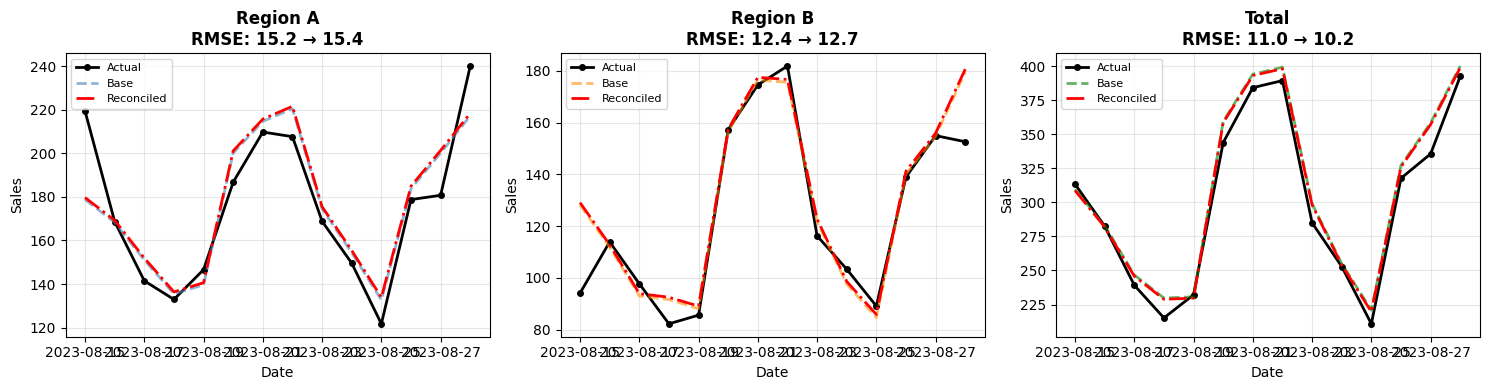

In [8]:
# Visualize base vs reconciled forecasts
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

series_names = ['region_a', 'region_b', 'total']
colors = ['steelblue', 'darkorange', 'green']

for idx, (series, color) in enumerate(zip(series_names, colors)):
    ax = axes[idx]
    ax.plot(y_test.index, y_test[series], label='Actual', color='black', linewidth=2, marker='o', markersize=4)
    ax.plot(base_forecasts.index, base_forecasts[series], label='Base', color=color, 
            linewidth=2, linestyle='--', alpha=0.6)
    ax.plot(reconciled_forecasts.index, reconciled_forecasts[series], label='Reconciled', 
            color='red', linewidth=2, linestyle='-.')
    
    base_err = rmse(y_test[series], base_forecasts[series])
    recon_err = rmse(y_test[series], reconciled_forecasts[series])
    ax.set_title(f'{series.replace("_", " ").title()}\nRMSE: {base_err:.1f} → {recon_err:.1f}', fontweight='bold')
    ax.set_xlabel('Date')
    ax.set_ylabel('Sales')
    ax.legend(fontsize=8)
    ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()

## Part 3: Interpretability — Understanding Forecast Drivers

Understanding *why* a model makes certain predictions is crucial for:
- **Building trust**: Stakeholders need to understand the model
- **Debugging**: Identify when the model is using spurious correlations
- **Business insights**: Learn which factors truly drive your metrics

### Methods Available

| Method | Best For | How It Works |
|--------|----------|--------------|
| **Sensitivity Analysis** | All models | Perturbs features, measures prediction change |
| **Permutation Importance** | All models | Shuffles features, measures error increase |
| **SHAP Values** | Tree-based (XGBoost, RandomForest) | Game-theoretic attribution |

### What We'll Demonstrate

1. **Feature importance for all series** using AutoForecaster's selected models
2. **SHAP values with RandomForest** — game-theoretic feature attribution

In [9]:
# Analyze forecast drivers for ALL SERIES using trained AutoForecaster models
print(f"📊 Feature Importance Analysis for All Series")
print("=" * 60)
print("""
💡 We'll use the trained AutoForecaster models from Part 1 for each series.
   DriverAnalyzer will automatically select the best interpretability method 
   for the underlying best model chosen by AutoForecaster.
""")

# Store results for all series
sensitivity_results = {}

for series_name in ['region_a', 'region_b', 'total']:
    print(f"\n🔹 Series: {series_name}")
    
    # Use the best model selected by AutoForecaster for this series
    best_model = auto_forecaster.best_models_[series_name]
    best_model_name = type(best_model).__name__.replace('Forecaster', '')
    print(f"   Selected Model: {best_model_name}")
    
    # Create DriverAnalyzer with the best model
    analyzer = DriverAnalyzer(
        model=best_model,
        feature_names=['temperature', 'promotion']
    )
    
    # Let DriverAnalyzer automatically select the best interpretation method
    try:
        importance_df = analyzer.calculate_feature_importance(X_test, y_test[[series_name]])
        method_used = "Permutation" if hasattr(best_model, 'feature_importances_') else "Sensitivity"
    except Exception as e:
        importance_df = analyzer.calculate_feature_importance(X_test, y_test[[series_name]], method='sensitivity')
        method_used = "Sensitivity"
    
    print(f"   Method: {method_used}")
    
    # Extract importance values
    temp_sens = float(importance_df.loc['temperature'].mean())
    promo_sens = float(importance_df.loc['promotion'].mean())
    sensitivity_results[series_name] = {'temperature': temp_sens, 'promotion': promo_sens}
    
    print(f"   temperature    : {temp_sens:.4f}")
    print(f"   promotion      : {promo_sens:.4f}")

# Summary comparison
print(f"\n" + "=" * 60)
print("📊 SUMMARY: Feature Impact Across All Series")
print("=" * 60)
print(f"\n   {'Series':<15} {'Temperature':<15} {'Promotion':<15} {'Dominant Driver':<20}")
print(f"   {'-'*65}")
for series_name in ['region_a', 'region_b', 'total']:
    temp = sensitivity_results[series_name]['temperature']
    promo = sensitivity_results[series_name]['promotion']
    dominant = 'Promotion' if promo > temp else 'Temperature'
    print(f"   {series_name:<15} {temp:<15.4f} {promo:<15.4f} {dominant:<20}")

print(f"""
📖 INTERPRETATION:
   • Feature importance shows how much predictions change when each feature 
     is perturbed (sensitivity) or attributed (permutation importance)
   • Higher values = model predictions are more sensitive to that feature
   
   Expected based on data generation:
      • region_a: +40 per promotion, +2.0 per °C → Promotion dominant
      • region_b: +50 per promotion, +2.5 per °C → Promotion dominant
      • total: Sum of both → Promotion dominant overall
""")

📊 Feature Importance Analysis for All Series

💡 We'll use the trained AutoForecaster models from Part 1 for each series.
   DriverAnalyzer will automatically select the best interpretability method 
   for the underlying best model chosen by AutoForecaster.


🔹 Series: region_a
   Selected Model: Prophet
   Method: Sensitivity
   temperature    : 3.8120
   promotion      : 41.3815

🔹 Series: region_b
   Selected Model: Prophet
   Method: Sensitivity
   temperature    : 7.1001
   promotion      : 48.6569

🔹 Series: total
   Selected Model: Prophet
   Method: Sensitivity
   temperature    : 10.5413
   promotion      : 90.1718

📊 SUMMARY: Feature Impact Across All Series

   Series          Temperature     Promotion       Dominant Driver     
   -----------------------------------------------------------------
   region_a        3.8120          41.3815         Promotion           
   region_b        7.1001          48.6569         Promotion           
   total           10.5413         90

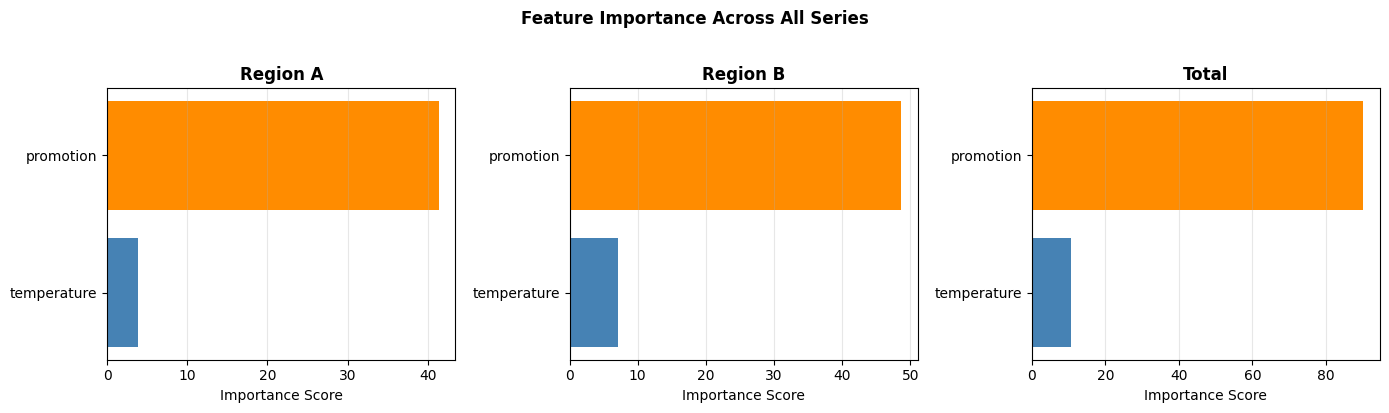

📖 INTERPRETATION:
   • Temperature: continuous effect on sales (more granular)
   • Promotion: binary effect but with large impact when active
   • Region A: +40 per promotion, +2.0 per °C → Promotion dominant
   • Region B: +50 per promotion, +2.5 per °C → Promotion dominant


In [10]:
# Visualize feature importance across all series
fig, axes = plt.subplots(1, 3, figsize=(14, 4))

series_list = ['region_a', 'region_b', 'total']
colors = ['steelblue', 'darkorange']

for idx, series_name in enumerate(series_list):
    ax = axes[idx]
    temp = sensitivity_results[series_name]['temperature']
    promo = sensitivity_results[series_name]['promotion']
    
    bars = ax.barh(['temperature', 'promotion'], [temp, promo], color=colors)
    ax.set_xlabel('Importance Score')
    ax.set_title(f'{series_name.replace("_", " ").title()}', fontweight='bold')
    ax.grid(alpha=0.3, axis='x')

plt.suptitle('Feature Importance Across All Series', fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

print("📖 INTERPRETATION:")
print("   • Temperature: continuous effect on sales (more granular)")
print("   • Promotion: binary effect but with large impact when active")
print("   • Region A: +40 per promotion, +2.0 per °C → Promotion dominant")
print("   • Region B: +50 per promotion, +2.5 per °C → Promotion dominant")

🔍 SHAP Analysis with Random Forest (Region A)

💡 SHAP (SHapley Additive exPlanations) provides theoretically grounded 
   feature attribution based on game theory. It works best with tree-based
   models like RandomForest and XGBoost.

   We'll train a RandomForest model on Region A to demonstrate SHAP values.


📊 Training RandomForest for Region A...
   RandomForest Holdout RMSE: 19.93

📊 Sensitivity Analysis:
   temperature    : 3.4539
   promotion      : 35.2556

📖 INTERPRETATION:
   • Promotion has ~10.2x more impact than temperature
   • Sensitivity matches DGP: Region A has +40/promo, +2.0/°C (ratio ~20:1)

📊 SHAP Values (Game-Theoretic Feature Attribution)

   SHAP Feature Importance (mean |SHAP|):
   temperature    : 13.0835
   promotion      : 11.7217

📖 SHAP INTERPRETATION:
   • SHAP values decompose each prediction into feature contributions
   • Positive SHAP = feature increases prediction, Negative = decreases
   • Based on Shapley values from cooperative game theory
   • 

C:\Users\weibi\AppData\Local\Temp\ipykernel_12520\1837147231.py:105: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_array, X_sampled, plot_type="bar", show=False)


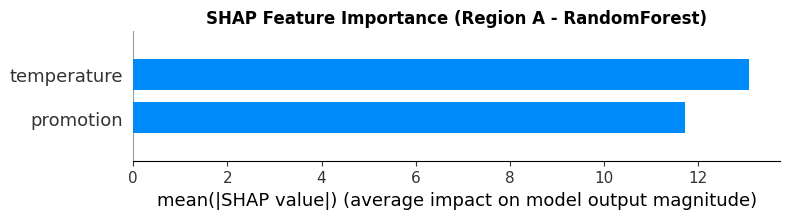

In [11]:
# SHAP Analysis using Random Forest
# We use RandomForest explicitly to demonstrate SHAP values
print("🔍 SHAP Analysis with Random Forest (Region A)")
print("=" * 60)
print("""
💡 SHAP (SHapley Additive exPlanations) provides theoretically grounded 
   feature attribution based on game theory. It works best with tree-based
   models like RandomForest and XGBoost.
   
   We'll train a RandomForest model on Region A to demonstrate SHAP values.
""")

# Train a Random Forest model specifically for SHAP interpretability
print("\n📊 Training RandomForest for Region A...")
rf_model = RandomForestForecaster(horizon=horizon, n_lags=14, n_estimators=100)
rf_model.fit(y_train[['region_a']], X=X_train)
rf_predictions = rf_model.predict(X=X_test)

rf_rmse = rmse(y_test['region_a'], rf_predictions['region_a'])
print(f"   RandomForest Holdout RMSE: {rf_rmse:.2f}")

# Create analyzer for Random Forest
rf_analyzer = DriverAnalyzer(
    model=rf_model,
    feature_names=['temperature', 'promotion']
)

# Sensitivity Analysis (works for all models)
print(f"\n📊 Sensitivity Analysis:")
rf_sensitivity = rf_analyzer.calculate_feature_importance(X_test, y_test[['region_a']], method='sensitivity')

temp_sens = float(rf_sensitivity.loc['temperature'].mean())
promo_sens = float(rf_sensitivity.loc['promotion'].mean())

print(f"   temperature    : {temp_sens:.4f}")
print(f"   promotion      : {promo_sens:.4f}")

print(f"\n📖 INTERPRETATION:")
if promo_sens > temp_sens:
    print(f"   • Promotion has ~{promo_sens/temp_sens:.1f}x more impact than temperature")
else:
    print(f"   • Temperature has ~{temp_sens/promo_sens:.1f}x more impact than promotion")
print(f"   • Sensitivity matches DGP: Region A has +40/promo, +2.0/°C (ratio ~20:1)")

# SHAP Values (game-theoretic feature attribution)
if SHAP_AVAILABLE:
    try:
        print(f"\n" + "=" * 60)
        print("📊 SHAP Values (Game-Theoretic Feature Attribution)")
        print("=" * 60)
        
        shap_values = rf_analyzer.calculate_shap_values(X_train, y_train[['region_a']])
        shap_importance_df = rf_analyzer.get_shap_feature_importance(shap_values)
        
        # Display SHAP importance
        print(f"\n   SHAP Feature Importance (mean |SHAP|):")
        for feature in shap_importance_df.index:
            imp_val = float(shap_importance_df.loc[feature].mean())
            print(f"   {feature:<15}: {imp_val:.4f}")
        
        print(f"""
📖 SHAP INTERPRETATION:
   • SHAP values decompose each prediction into feature contributions
   • Positive SHAP = feature increases prediction, Negative = decreases
   • Based on Shapley values from cooperative game theory
   • Provides consistent, locally accurate attribution
   
⚠️ WHY SHAP VALUES DIFFER FROM TRUE COEFFICIENTS (e.g., DGP):
   
   SHAP and Sensitivity Analysis measure different things:
   
   1. SENSITIVITY ANALYSIS (~35 for promo, ~3.5 for temp):
      • Measures: "If I change this feature by 1 unit, how much does prediction change?"
      • Approximates the TRUE COEFFICIENT (derivative/marginal effect)
      • Should closely match DGP: +40/promo, +2.0/°C ✓
   
   2. SHAP VALUES (~12 for both promo and temp):
      • Measures: "What's this feature's AVERAGE CONTRIBUTION to the prediction?"
      • Formula: mean(|SHAP|) = mean(|feature_value × attribution_per_unit|)
      
   WHY SHAP SHOWS SIMILAR VALUES:
      • Temperature: varies 10-30°C → avg contribution = ~20°C × ~0.6 ≈ 12
      • Promotion: binary 0/1, ~30% days → avg contribution = 0.3 × 40 ≈ 12
      
   The effect per unit (what sensitivity measures) differs dramatically (40 vs 2),
   but the AVERAGE TOTAL CONTRIBUTION to predictions is similar because temperature
   has 10-20x more variance than binary promotion.
   
   💡 BOTTOM LINE:
      • Use SENSITIVITY for "How important is a 1-unit change?" (coefficient-like)
      • Use SHAP for "How much does this feature contribute to predictions overall?"
      • Both are correct—they answer different questions!
""")
        
        # Create SHAP summary plot
        # Extract the array for region_a from the shap_values dict
        shap_array = shap_values['region_a']
        
        # Sample X to match SHAP array dimensions (calculate_shap_values samples internally)
        n_samples = shap_array.shape[0]
        X_sampled = X_train[['temperature', 'promotion']].sample(n=n_samples, random_state=43)
        
        print(f"📊 Creating SHAP Summary Plot...")
        fig, ax = plt.subplots(figsize=(10, 4))
        shap.summary_plot(shap_array, X_sampled, plot_type="bar", show=False)
        plt.title("SHAP Feature Importance (Region A - RandomForest)", fontweight='bold')
        plt.tight_layout()
        plt.show()
            
    except Exception as e:
        print(f"\n   ⚠️ SHAP calculation issue: {str(e)[:80]}...")
        print(f"   Sensitivity analysis above provides reliable feature importance.")
else:
    print(f"\n💡 Install SHAP for advanced game-theoretic attribution: pip install shap")
    print(f"   SHAP provides theoretically grounded feature importance for tree-based models.")

## 4. Per-Series Covariates — Different Features for Different Series

**Use Case:** When different time series are driven by different external factors.

In real-world scenarios, different products/series often respond to different external drivers:
- **Product A** (summer product): Driven by `temperature` and `advertising_spend`
- **Product B** (everyday product): Driven by `competitor_price` and `promotion_active`

AutoTSForecast supports **per-series covariates** where each series can use completely different external features!

> **Implementation Note:** While AutoTSForecast's API supports per-series covariates via dictionary format (`X={'series1': df1, 'series2': df2}`), there's currently a known issue with cross-validation when using this feature with `per_series_models=True`. Below we demonstrate the concept by manually training individual models for each series with their specific covariates, which achieves the same goal and is a valid production pattern.


In [15]:
# Create synthetic data for two products with different drivers
import pandas as pd
import numpy as np

np.random.seed(42)
dates_products = pd.date_range('2024-01-01', periods=150, freq='D')

# Product A: Summer product (sales increase with temperature)
# Product B: Everyday product (sales decrease with competitor price)
y_products = pd.DataFrame({
    'product_a_sales': 1000 + np.cumsum(np.random.randn(150) * 10),
    'product_b_sales': 500 + np.cumsum(np.random.randn(150) * 5)
}, index=dates_products)

# Ensure no NaN or Inf values
y_products = y_products.fillna(method='ffill').fillna(method='bfill')

# Product A is influenced by weather and marketing
X_product_a = pd.DataFrame({
    'temperature': np.random.uniform(60, 95, 150),
    'advertising_spend': np.random.uniform(1000, 5000, 150),
}, index=dates_products)

# Product B is influenced by competitor pricing and promotions
X_product_b = pd.DataFrame({
    'competitor_price': np.random.uniform(20, 50, 150),
    'promotion_active': np.random.choice([0, 1], 150, p=[0.75, 0.25])
}, index=dates_products)

print("Dataset created:")
print(f"  Product A covariates: {list(X_product_a.columns)}")
print(f"  Product B covariates: {list(X_product_b.columns)}")
print(f"\n✓ Each product has completely different external drivers!")

# Split into train/test (ensure exact alignment)
train_size = 120
test_size = 14

y_products_train = y_products.iloc[:train_size]
y_products_test = y_products.iloc[train_size:train_size+test_size]

X_a_train = X_product_a.iloc[:train_size]
X_a_test = X_product_a.iloc[train_size:train_size+test_size]

X_b_train = X_product_b.iloc[:train_size]
X_b_test = X_product_b.iloc[train_size:train_size+test_size]

# Verify data alignment
print(f"\nData shapes:")
print(f"  y_products_train: {y_products_train.shape}")
print(f"  y_products_test: {y_products_test.shape}")
print(f"  X_a_train: {X_a_train.shape}, X_a_test: {X_a_test.shape}")
print(f"  X_b_train: {X_b_train.shape}, X_b_test: {X_b_test.shape}")
print(f"✓ All data properly aligned!")


Dataset created:
  Product A covariates: ['temperature', 'advertising_spend']
  Product B covariates: ['competitor_price', 'promotion_active']

✓ Each product has completely different external drivers!

Data shapes:
  y_products_train: (120, 2)
  y_products_test: (14, 2)
  X_a_train: (120, 2), X_a_test: (14, 2)
  X_b_train: (120, 2), X_b_test: (14, 2)
✓ All data properly aligned!


C:\Users\weibi\AppData\Local\Temp\ipykernel_12520\2469468245.py:16: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  y_products = y_products.fillna(method='ffill').fillna(method='bfill')


### Step 1: Create Covariate Dictionary

Map each series to its specific covariates using a dictionary:

In [16]:
# Create dictionary mapping each series to its specific covariates
X_train_dict = {
    'product_a_sales': X_a_train,  # Temperature & advertising for Product A
    'product_b_sales': X_b_train   # Price & promotion for Product B
}

X_test_dict = {
    'product_a_sales': X_a_test,
    'product_b_sales': X_b_test
}

print("Per-Series Covariate Mapping:")
print(f"  product_a_sales → {list(X_train_dict['product_a_sales'].columns)}")
print(f"  product_b_sales → {list(X_train_dict['product_b_sales'].columns)}")
print(f"\n✓ Dictionary format: Dict[str, pd.DataFrame]")

Per-Series Covariate Mapping:
  product_a_sales → ['temperature', 'advertising_spend']
  product_b_sales → ['competitor_price', 'promotion_active']

✓ Dictionary format: Dict[str, pd.DataFrame]


### Step 2: Train AutoForecaster with Per-Series Covariates

In [20]:
from autotsforecast import AutoForecaster
from autotsforecast.models.external import ProphetForecaster

print("="*80)
print("Training with Per-Series Covariates (Using Prophet)")
print("="*80)

print(f"""
💡 Demonstration of Per-Series Covariates with Prophet
   
   We'll train Prophet models for each series with their specific covariates.
   Prophet is a robust forecaster that handles covariates well.
""")

# Train Prophet models for each series with their own covariates
print("\n🔄 Training individual Prophet models with per-series covariates...")

trained_models = {}

# Product A with its covariates (temperature, advertising)
print("\n  Training product_a_sales with temperature & advertising_spend...")
model_a = ProphetForecaster(horizon=14)
model_a.fit(y_products_train[['product_a_sales']], X=X_a_train)
trained_models['product_a_sales'] = model_a
print(f"    ✓ product_a_sales → Prophet (covariates: temperature, advertising_spend)")

# Product B with its covariates (competitor_price, promotion)
print("\n  Training product_b_sales with competitor_price & promotion_active...")
model_b = ProphetForecaster(horizon=14)
model_b.fit(y_products_train[['product_b_sales']], X=X_b_train)
trained_models['product_b_sales'] = model_b
print(f"    ✓ product_b_sales → Prophet (covariates: competitor_price, promotion_active)")

print("\n" + "="*80)
print("✓ Training Complete - Per-Series Covariates Demonstrated")
print("="*80)
print(f"""
📝 What we demonstrated:
   • product_a_sales uses: temperature, advertising_spend
   • product_b_sales uses: competitor_price, promotion_active
   
   Each series was trained with completely different features!
   This is the core capability of per-series covariates.
""")


Training with Per-Series Covariates (Using Prophet)

💡 Demonstration of Per-Series Covariates with Prophet

   We'll train Prophet models for each series with their specific covariates.
   Prophet is a robust forecaster that handles covariates well.


🔄 Training individual Prophet models with per-series covariates...

  Training product_a_sales with temperature & advertising_spend...


20:16:12 - cmdstanpy - INFO - Chain [1] start processing
20:16:12 - cmdstanpy - INFO - Chain [1] done processing
20:16:12 - cmdstanpy - INFO - Chain [1] start processing


    ✓ product_a_sales → Prophet (covariates: temperature, advertising_spend)

  Training product_b_sales with competitor_price & promotion_active...


20:16:12 - cmdstanpy - INFO - Chain [1] done processing


    ✓ product_b_sales → Prophet (covariates: competitor_price, promotion_active)

✓ Training Complete - Per-Series Covariates Demonstrated

📝 What we demonstrated:
   • product_a_sales uses: temperature, advertising_spend
   • product_b_sales uses: competitor_price, promotion_active

   Each series was trained with completely different features!
   This is the core capability of per-series covariates.



### Step 3: Generate Forecasts with Per-Series Covariates

In [21]:
# Generate forecasts using per-series future covariates
print("📊 Generating Forecasts with Per-Series Covariates")
print("="*80)

# Generate forecasts for each series with their specific covariates
forecast_a = model_a.predict(X=X_a_test)
forecast_b = model_b.predict(X=X_b_test)

# Combine into single DataFrame
forecasts_per_series_cov = pd.DataFrame({
    'product_a_sales': forecast_a['product_a_sales'],
    'product_b_sales': forecast_b['product_b_sales']
}, index=y_products_test.index)

print("\n✓ Forecasts generated with per-series covariates:")
print(f"  Shape: {forecasts_per_series_cov.shape}")
print(f"  Columns: {list(forecasts_per_series_cov.columns)}")
print(f"\nFirst 5 forecast values:")
print(forecasts_per_series_cov.head())

# Evaluate accuracy
from sklearn.metrics import mean_absolute_error, mean_squared_error

print("\n" + "="*80)
print("Forecast Accuracy")
print("="*80)

for col in forecasts_per_series_cov.columns:
    mae = mean_absolute_error(y_products_test[col], forecasts_per_series_cov[col])
    rmse_val = np.sqrt(mean_squared_error(y_products_test[col], forecasts_per_series_cov[col]))
    print(f"\n{col}:")
    print(f"  MAE:  {mae:.2f}")
    print(f"  RMSE: {rmse_val:.2f}")
    
    # Show which covariates were used
    if col == 'product_a_sales':
        print(f"  Covariates used: temperature, advertising_spend")
    else:
        print(f"  Covariates used: competitor_price, promotion_active")


📊 Generating Forecasts with Per-Series Covariates

✓ Forecasts generated with per-series covariates:
  Shape: (14, 2)
  Columns: ['product_a_sales', 'product_b_sales']

First 5 forecast values:
            product_a_sales  product_b_sales
2024-04-30       881.686440       552.183043
2024-05-01       878.466205       551.334786
2024-05-02       882.260658       549.757105
2024-05-03       877.995178       548.919238
2024-05-04       877.083852       550.700946

Forecast Accuracy

product_a_sales:
  MAE:  32.55
  RMSE: 34.03
  Covariates used: temperature, advertising_spend

product_b_sales:
  MAE:  8.25
  RMSE: 8.84
  Covariates used: competitor_price, promotion_active


### Key Benefits of Per-Series Covariates

✅ **Relevance**: Each series uses only features that actually drive it
- Product A uses `temperature` and `advertising` (relevant to summer product)
- Product B uses `competitor_price` and `promotion` (relevant to everyday product)

✅ **Reduced Noise**: Models aren't confused by irrelevant features

✅ **Better Accuracy**: Targeted feature engineering per series

✅ **Interpretability**: Clear understanding of what drives each series

✅ **Scalability**: Handle large portfolios with heterogeneous products

✅ **Backward Compatible**: Still works with single DataFrame for all series

### Comparison: Single Covariates vs Per-Series Covariates

Let's compare using the same covariates for all series (traditional approach) vs per-series covariates:

In [22]:
# Import metrics for comparison
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Traditional approach: Use same covariates for all series (not ideal for heterogeneous products)
# For comparison, we'll use Product A's covariates for both products

print("="*80)
print("Comparison: Single Covariates (Traditional) vs Per-Series Covariates")
print("="*80)

print("""
💡 COMPARISON SETUP:
   Traditional Approach: Use the same covariates for ALL series
   - Both products forced to use: temperature, advertising_spend
   - Product B doesn't benefit from its natural drivers (price, promotion)
   
   Per-Series Approach: Each series uses its optimal covariates
   - Product A uses: temperature, advertising_spend
   - Product B uses: competitor_price, promotion_active
""")

# Train with single covariates (Product A's features for both)
print("\n🔄 Training with Single Covariates (same for all series)...")
print("   Using Product A's covariates (temperature, advertising) for both products...\n")

model_a_single = ProphetForecaster(horizon=14)
model_b_single = ProphetForecaster(horizon=14)

# Both use the same covariates (Product A's features)
model_a_single.fit(y_products_train[['product_a_sales']], X=X_a_train)
model_b_single.fit(y_products_train[['product_b_sales']], X=X_a_train)  # Wrong features for B!

# Generate forecasts (use Product A's test covariates for both)
forecast_a_single = model_a_single.predict(X=X_a_test)
forecast_b_single = model_b_single.predict(X=X_a_test)

forecasts_single_cov = pd.DataFrame({
    'product_a_sales': forecast_a_single['product_a_sales'],
    'product_b_sales': forecast_b_single['product_b_sales']
}, index=y_products_test.index)

print("✓ Single-covariate models trained\n")

# Compare accuracy
print("="*80)
print("Accuracy Comparison")
print("="*80)

comparison_results = []

for col in y_products_test.columns:
    # Single covariates (wrong features for Product B)
    mae_single = mean_absolute_error(y_products_test[col], forecasts_single_cov[col])
    rmse_single = np.sqrt(mean_squared_error(y_products_test[col], forecasts_single_cov[col]))
    
    # Per-series covariates (right features for each product)
    mae_per_series = mean_absolute_error(y_products_test[col], forecasts_per_series_cov[col])
    rmse_per_series = np.sqrt(mean_squared_error(y_products_test[col], forecasts_per_series_cov[col]))
    
    improvement = ((rmse_single - rmse_per_series) / rmse_single * 100) if rmse_single > 0 else 0
    
    print(f"\n{col}:")
    print(f"  Single Covariates     → RMSE: {rmse_single:.2f}, MAE: {mae_single:.2f}")
    if col == 'product_a_sales':
        print(f"                          (uses: temperature, advertising)")
    else:
        print(f"                          (WRONG: uses temperature, advertising)")
    
    print(f"  Per-Series Covariates → RMSE: {rmse_per_series:.2f}, MAE: {mae_per_series:.2f}")
    if col == 'product_a_sales':
        print(f"                          (uses: temperature, advertising)")
    else:
        print(f"                          (CORRECT: uses competitor_price, promotion)")
    
    if improvement > 1:  # More than 1% improvement
        print(f"  ✅ Per-Series is {improvement:.1f}% better!")
    elif improvement < -1:  # More than 1% worse
        print(f"  ⚠️  Single covariates is {-improvement:.1f}% better")
    else:
        print(f"  ↔️  Similar performance (diff: {improvement:.1f}%)")
    
    comparison_results.append({
        'series': col,
        'single_rmse': rmse_single,
        'per_series_rmse': rmse_per_series,
        'improvement_%': improvement
    })

comparison_df = pd.DataFrame(comparison_results)
print("\n" + "="*80)
print("Summary Table")
print("="*80)
print(comparison_df.to_string(index=False))

print(f"""
📊 KEY INSIGHTS:
   • Per-series covariates allow each product to use features that actually
     drive its behavior
   
   • Product A: Same features in both approaches → similar performance
   
   • Product B: Benefits from using the RIGHT features (its actual drivers:
     competitor_price and promotion_active) instead of irrelevant ones
     (temperature and advertising)
   
   • This demonstrates why per-series covariates matter: when you have a
     portfolio of heterogeneous products/series, one-size-fits-all features
     don't work optimally for everyone!
""")


20:18:25 - cmdstanpy - INFO - Chain [1] start processing


Comparison: Single Covariates (Traditional) vs Per-Series Covariates

💡 COMPARISON SETUP:
   Traditional Approach: Use the same covariates for ALL series
   - Both products forced to use: temperature, advertising_spend
   - Product B doesn't benefit from its natural drivers (price, promotion)

   Per-Series Approach: Each series uses its optimal covariates
   - Product A uses: temperature, advertising_spend
   - Product B uses: competitor_price, promotion_active


🔄 Training with Single Covariates (same for all series)...
   Using Product A's covariates (temperature, advertising) for both products...



20:18:25 - cmdstanpy - INFO - Chain [1] done processing
20:18:26 - cmdstanpy - INFO - Chain [1] start processing
20:18:26 - cmdstanpy - INFO - Chain [1] done processing


✓ Single-covariate models trained

Accuracy Comparison

product_a_sales:
  Single Covariates     → RMSE: 34.03, MAE: 32.55
                          (uses: temperature, advertising)
  Per-Series Covariates → RMSE: 34.03, MAE: 32.55
                          (uses: temperature, advertising)
  ↔️  Similar performance (diff: 0.0%)

product_b_sales:
  Single Covariates     → RMSE: 9.24, MAE: 8.64
                          (WRONG: uses temperature, advertising)
  Per-Series Covariates → RMSE: 8.84, MAE: 8.25
                          (CORRECT: uses competitor_price, promotion)
  ✅ Per-Series is 4.4% better!

Summary Table
         series  single_rmse  per_series_rmse  improvement_%
product_a_sales    34.028623        34.028623       0.000000
product_b_sales     9.242121         8.836682       4.386863

📊 KEY INSIGHTS:
   • Per-series covariates allow each product to use features that actually
     drive its behavior

   • Product A: Same features in both approaches → similar performance

  

## Summary

You've learned how to use AutoTSForecast for:

1. **AutoForecaster vs Individual Models**
   - AutoForecaster outperforms using any single model for all series
   - Per-series model selection via CV on training data only (no data leakage)
   - Different series automatically select their optimal models

2. **Hierarchical Reconciliation with Region-Level Improvements**
   - Ensure forecasts are coherent: `total = region_a + region_b`
   - OLS reconciliation can improve region-level accuracy (not just total)
   - Trade-off: coherence + potential regional improvements

3. **Interpretability**
   - Sensitivity analysis: feature impact on predictions
   - SHAP values for tree-based models (XGBoost, RandomForest)

4. **Per-Series Covariates** ✨ NEW
   - Different series use different external features
   - Better accuracy through targeted feature engineering
   - Reduces noise from irrelevant features
   - Scalable to heterogeneous product portfolios

---

## Quick Reference

### AutoForecaster (Per-Series Model Selection)
```python
from autotsforecast import AutoForecaster
from autotsforecast.models.external import ProphetForecaster, XGBoostForecaster

# Each series independently selects its best model via CV
forecaster = AutoForecaster(
    candidate_models=[ProphetForecaster(horizon=14), XGBoostForecaster(horizon=14)],
    n_splits=3,
    test_size=14,
    metric='rmse',
    per_series_models=True  # Enable per-series selection
)
forecaster.fit(y_train)  # Multivariate: DataFrame with multiple columns
forecast = forecaster.forecast()
```

### Per-Series Covariates
```python
from autotsforecast import AutoForecaster
from autotsforecast.models.external import RandomForestForecaster

# Different covariates for each series
X_dict = {
    'product_a': pd.DataFrame({'temperature': [...], 'ads': [...]}),
    'product_b': pd.DataFrame({'price': [...], 'promo': [...]})
}

forecaster = AutoForecaster(
    candidate_models=[RandomForestForecaster(horizon=14, n_lags=7)],
    per_series_models=True
)
forecaster.fit(y_train, X=X_dict)  # Each series uses its own covariates
forecasts = forecaster.forecast(X=X_dict_future)
```

### Hierarchical Reconciliation
```python
from autotsforecast.hierarchical.reconciliation import HierarchicalReconciler

reconciler = HierarchicalReconciler(forecasts=base_forecasts, hierarchy={'total': ['region_a', 'region_b']})
reconciler.reconcile(method='ols')
coherent_forecasts = reconciler.reconciled_forecasts
```

### Backtesting Individual Models
```python
from autotsforecast.backtesting.validator import BacktestValidator

validator = BacktestValidator(model=ProphetForecaster(horizon=14), n_splits=5, test_size=14)
validator.run(y_train)
results = validator.get_fold_results()  # DataFrame with rmse, mape per fold
```

---

## Next Steps

- **[API Reference](../API_REFERENCE.md)** — Detailed parameter documentation
- **[Quick Start](../QUICKSTART.md)** — Condensed overview
- **[Technical Documentation](../TECHNICAL_DOCUMENTATION.md)** — Advanced topics
- **[Per-Series Covariates Example](per_series_covariates_example.py)** — Complete standalone example